<a href="https://colab.research.google.com/github/mohripan/Machine-Learning/blob/main/Face_Resto_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install basicsr
!pip install --upgrade --force-reinstall --no-deps albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%%shell
cp '/content/gdrive/My Drive/KaggleAPI/kaggle.json' kaggle.json
pip install -q kaggle
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d sergiovirahonda/shape-predictor-68-face-landmarksdat

 97% 67.0M/69.3M [00:03<00:00, 23.6MB/s]
100% 69.3M/69.3M [00:03<00:00, 19.3MB/s]


In [4]:
!unzip /content/shape-predictor-68-face-landmarksdat.zip

Archive:  /content/shape-predictor-68-face-landmarksdat.zip
  inflating: shape_predictor_68_face_landmarks.dat  


In [5]:
import torch
import torch.nn as nn
from torch.nn import init as init
from torch.nn.modules.batchnorm import _BatchNorm
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from torch.nn.utils import spectral_norm

In [6]:
class CustomDownsampleUnshuffle(nn.Module):
  def __init__(self):
    super(CustomDownsampleUnshuffle, self).__init__()
    self.pixel_unshuffle_2x = nn.PixelUnshuffle(2)
    self.pixel_unshuffle_4x = nn.PixelUnshuffle(4)

  def forward(self, x):
    # Downsample the image
    x2 = F.interpolate(x, scale_factor = 0.5, mode = 'bilinear', align_corners = False)
    x4 = F.interpolate(x, scale_factor = 0.25, mode = 'bilinear', align_corners = False)

    # Pixel Unshuffle
    x_unshuffled_4x = self.pixel_unshuffle_4x(x)
    x2_unshuffled_2x = self.pixel_unshuffle_2x(x2)

    # Concatenate along the channel dimension
    x_concat = torch.cat((x_unshuffled_4x, x2_unshuffled_2x, x4), dim = 1)
    return x_concat

In [7]:
import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving Sabina-Altynbekova-HD-Wallpaper.jpg to Sabina-Altynbekova-HD-Wallpaper.jpg
Saving waifu.jpg to waifu.jpg
move Sabina-Altynbekova-HD-Wallpaper.jpg to upload/Sabina-Altynbekova-HD-Wallpaper.jpg
move waifu.jpg to upload/waifu.jpg


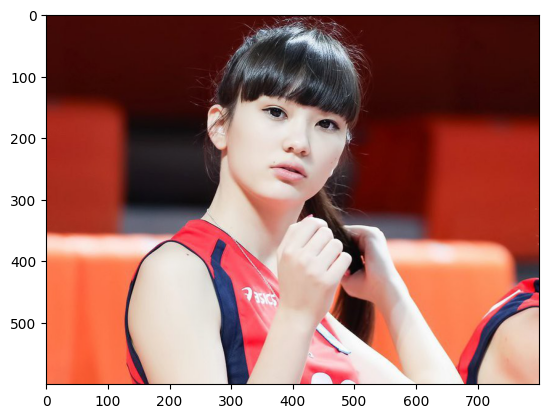

In [8]:
def display(img):
  image = Image.open(img)
  image = np.array(image)
  plt.imshow(image)

input_folder = 'upload'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))

for input_path in input_list:
  display(input_path)

In [9]:
def change_to_torch(img):
  with torch.no_grad():
    img_copy = np.copy(img)
    img_copy = torch.from_numpy(img_copy)
    img_copy = img_copy.float()
    img_copy = img_copy / 255
    img_copy = img_copy.permute(2, 0, 1)
    return img_copy

image = Image.open(input_list[0])
image = np.array(image)

image = change_to_torch(image)
print(image.shape)

torch.Size([3, 1280, 1920])


In [10]:
from PIL import Image
import cv2
import numpy as np

dir = 'upload'

images_dir = sorted([os.path.join(dir, f) for f in os.listdir(dir)])
images_filepaths = [*images_dir]

imgs = []

for i in images_filepaths:
  img = np.array(Image.open(i))
  img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)
  imgs.append(img)

In [11]:
!mkdir dataset

In [12]:
import numpy as np
from skimage.io import imsave
import os

# Create the dataset directory if it doesn't exist
if not os.path.exists('dataset'):
    os.makedirs('dataset')

# Iterate over the imgs list and save each image
for i, img in enumerate(imgs):
    # Create the filename
    file_name = f'dataset/image_{i}.png'
    # Save the image
    imsave(file_name, img)

In [13]:
def make_layer(basic_block, num_basic_block, **kwarg):
    """Make layers by stacking the same blocks.

    Args:
        basic_block (nn.module): nn.module class for basic block.
        num_basic_block (int): number of blocks.

    Returns:
        nn.Sequential: Stacked blocks in nn.Sequential.
    """
    layers = []
    for _ in range(num_basic_block):
        layers.append(basic_block(**kwarg))
    return nn.Sequential(*layers)

In [14]:
@torch.no_grad()
def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)

In [15]:
class ResidualDenseBlock(nn.Module):
    """Residual Dense Block.

    Used in RRDB block in ESRGAN.

    Args:
        num_feat (int): Channel number of intermediate features.
        num_grow_ch (int): Channels for each growth.
    """

    def __init__(self, num_feat=64, num_grow_ch=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_feat, num_grow_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv3 = nn.Conv2d(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv4 = nn.Conv2d(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv5 = nn.Conv2d(num_feat + 4 * num_grow_ch, num_feat, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        default_init_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        # Empirically, we use 0.2 to scale the residual for better performance
        return x5 * 0.2 + x

In [16]:
class RRDB(nn.Module):
    """Residual in Residual Dense Block.

    Used in RRDB-Net in ESRGAN.

    Args:
        num_feat (int): Channel number of intermediate features.
        num_grow_ch (int): Channels for each growth.
    """

    def __init__(self, num_feat, num_grow_ch=32):
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb2 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb3 = ResidualDenseBlock(num_feat, num_grow_ch)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        # Empirically, we use 0.2 to scale the residual for better performance
        return out * 0.2 + x

In [17]:
class RRDBNet(nn.Module):
    """Networks consisting of Residual in Residual Dense Block, which is used
    in ESRGAN.

    ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks.

    We extend ESRGAN for scale x2 and scale x1.
    Note: This is one option for scale 1, scale 2 in RRDBNet.
    We first employ the pixel-unshuffle (an inverse operation of pixelshuffle to reduce the spatial size
    and enlarge the channel size before feeding inputs into the main ESRGAN architecture.

    Args:
        num_in_ch (int): Channel number of inputs.
        num_out_ch (int): Channel number of outputs.
        num_feat (int): Channel number of intermediate features.
            Default: 64
        num_block (int): Block number in the trunk network. Defaults: 23
        num_grow_ch (int): Channels for each growth. Default: 32.
    """

    def __init__(self, num_in_ch, num_out_ch, num_feat=64, num_block=23, num_grow_ch=32):
        super(RRDBNet, self).__init__()
        self.pixel_unshuffle = CustomDownsampleUnshuffle()
        self.conv_first = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)
        self.body = make_layer(RRDB, num_block, num_feat=num_feat, num_grow_ch=num_grow_ch)
        self.conv_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        # upsample
        self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_afterup = nn.Conv2d(num_feat, 48, 3, 1, 1)
        self.conv_up2 = nn.PixelShuffle(4)
        self.conv_hr = nn.Conv2d(3, 3, 3, 1, 1)
        self.conv_last = nn.Conv2d(3, num_out_ch, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        feat = self.pixel_unshuffle(x)
        feat = self.conv_first(feat)
        body_feat = self.conv_body(self.body(feat))
        feat = feat + body_feat
        # upsample
        feat = self.lrelu(self.conv_up1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.conv_afterup(feat))
        feat = self.conv_up2(feat)
        feat = self.lrelu(self.conv_hr(feat))
        out = self.conv_last(self.lrelu(self.conv_hr(feat)))
        return out

In [18]:
model = RRDBNet(63, 3, num_block = 1)
img = torch.randn(1, 3, 512, 512)
print(img.shape)

torch.Size([1, 3, 512, 512])


In [19]:
def display_from_torch(img):
  img = img.squeeze(0)
  img = img.permute(1, 2, 0)
  img = img.cpu().numpy()

  plt.imshow(img)

In [20]:
img = Image.open(input_list[0])
img = np.array(img)

img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

print(img.shape)

img = change_to_torch(img)
img = img.unsqueeze(0)
print(img.shape)

(640, 960, 3)
torch.Size([1, 3, 640, 960])


In [21]:
img = change_to_torch(imgs[0])
img = img.unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 512, 512])


In [22]:
model = RRDBNet(63, 3, num_block = 1)
image = model(img)

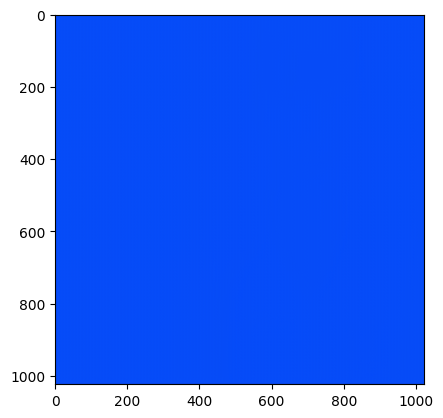

In [23]:
image = image.squeeze(0)
image = image.permute(1, 2, 0)
image = image + torch.abs(image.min())
image = image / image.max()
image = image.detach().numpy()

plt.imshow(image)

In [24]:
class VGG19Discriminator(nn.Module):
    def __init__(self):
        super(VGG19Discriminator, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 16 * 16, 4096),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [25]:
def logistic_loss(y_real, y_fake):
    real_loss = F.softplus(-y_real)  # -log( sigmoid(y_real) )
    fake_loss = F.softplus(y_fake)   # -log( 1 - sigmoid(y_fake) )
    return real_loss + fake_loss

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

discriminator = VGG19Discriminator().to(device)  # Move model to GPU memory

img = Image.open(input_list[0])
img = np.array(img)

img = cv2.resize(img, (512, 512))

real_images = change_to_torch(img).unsqueeze(0)
fake_images = torch.clone(real_images)

with torch.no_grad():
  # Assuming you have a real image batch `real_images` and generated `fake_images`
  real_images = real_images.to(device)  # Move tensors to GPU memory
  fake_images = fake_images.to(device)

  real_outputs = discriminator(real_images)
  fake_outputs = discriminator(fake_images)

  adv_loss = logistic_loss(real_outputs, fake_outputs)
  print(adv_loss)

tensor([[1.3832]], device='cuda:0')


In [27]:
import torch
from torchvision.models import vgg19
from torch import nn

# Load VGG19 without the fully-connected layers and set to evaluation mode
vgg = vgg19(pretrained=True).features[:23].eval()
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg = vgg.cuda()

class ReconstructionPerceptualLoss(nn.Module):
    def __init__(self, vgg):
      super(ReconstructionPerceptualLoss, self).__init__()
      self.vgg = vgg
      self.loss_fn = nn.L1Loss()

    def forward(self, x, y):
      reconstruction_loss = self.loss_fn(x, y)
      x_vgg, y_vgg = self.vgg(x), self.vgg(y)
      loss = self.loss_fn(x_vgg, y_vgg)
      return reconstruction_loss * 0.1 + loss

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 87.1MB/s]


In [28]:
reconstruction_loss = ReconstructionPerceptualLoss(vgg).to(device)  # Move model to GPU memory

img = Image.open(input_list[0])
img = np.array(img)

img = cv2.resize(img, (512, 512))

real_images = change_to_torch(img).unsqueeze(0)
fake_images = torch.clone(real_images)

with torch.no_grad():
  # Assuming you have a real image batch `real_images` and generated `fake_images`
  real_images = real_images.to(device)  # Move tensors to GPU memory
  fake_images = fake_images.to(device)

  rec_loss = reconstruction_loss(real_images, fake_images)
  print(rec_loss)

tensor(0., device='cuda:0')


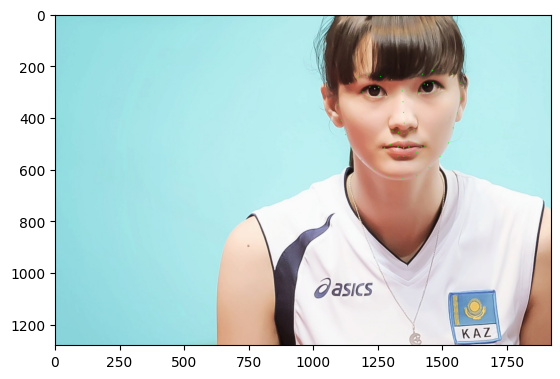

In [29]:
import cv2
import dlib

# Initialize dlib's face detector (HOG-based)
detector = dlib.get_frontal_face_detector()

# Load the predictor
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Load the image using OpenCV
img = cv2.imread(input_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Detect faces in the image
faces = detector(gray)

for face in faces:
    # Get the landmarks/parts for the face in box d.
    shape = predictor(gray, face)

    # Draw the face landmarks on the screen.
    for i in range(1, 68):  # There are 68 landmark points on each face
        cv2.circle(img, (shape.part(i).x, shape.part(i).y), 2, (0, 255, 0), -1)

plt.imshow(img)

In [246]:
def torch_to_numpy(tensor):
    # Permutes the tensor dimensions to BxHxWxC
    tensor = tensor.permute(0, 2, 3, 1)
    # Detaches the tensor from the graph and converts it to a numpy array
    return tensor.detach().cpu().numpy()

def get_roi_boxes(shape):
    # Define the indices for the eyes and mouth landmarks
    left_eye_indices = list(range(36, 42))
    right_eye_indices = list(range(42, 48))
    mouth_indices = list(range(48, 68))

    roi_lists = [left_eye_indices, right_eye_indices, mouth_indices]

    boxes = []
    for roi_list in roi_lists:
        xs = [shape.part(i).x for i in roi_list]
        ys = [shape.part(i).y for i in roi_list]
        x1, y1 = min(xs), min(ys)
        x2, y2 = max(xs), max(ys)
        boxes.append((x1, y1, x2, y2))

    return boxes

def resize_images(image_batch):
    image_batch = torch_to_numpy(image_batch)
    res_images = []
    for img in image_batch:
        res_img = cv2.resize(img, (32, 32))
        res_images.append(res_img)
    return np.array(res_images)

def get_boxes_batch(image_batch):
  # Load the predictor
  predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

  boxes_batch = []

  for img in image_batch:
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    for face in faces:
        # Get the landmarks/parts for the face in box d.
        shape = predictor(gray, face)


    boxes = get_roi_boxes(shape)
    boxes_batch.append(boxes)

  return np.array(boxes_batch)

def crop_rois(image_batch, boxes_batch):
    all_rois = []
    for image, boxes in zip(image_batch, boxes_batch):
        rois = []
        for box in boxes:
            x1, y1, x2, y2 = box
            roi = image[y1:y2, x1:x2, :]
            roi = cv2.resize(roi, (32, 32))
            rois.append(roi)
        all_rois.append(rois)
    return np.array(all_rois)

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a, b, c * d)  # reshape the tensor to vectorize the feature maps

    G = torch.bmm(features, features.transpose(1, 2))  # compute the Gram product

    # normalize the values of the gram matrix
    # by dividing by the number of element in each feature maps
    G = G.div(b * c * d)

    return G

In [254]:
import dlib
from torchvision.models import vgg19

# Load VGG19 without the fully-connected layers and set to evaluation mode
vgg = vgg19(pretrained=True).features[:23].eval()

class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(LocalDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(8192, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class FacialComponentLoss(nn.Module):
    def __init__(self, local_discriminators, device = 'cuda', vgg = vgg):
        super(FacialComponentLoss, self).__init__()
        self.local_discriminators = local_discriminators
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.device = device
        self.vgg = vgg

    def forward(self, real_images, fake_images):
        total_loss = 0

        real_images = torch_to_numpy(real_images) * 255
        real_images = real_images.astype(np.uint8)
        fake_images = torch_to_numpy(fake_images) * 255
        fake_images = fake_images.astype(np.uint8)

        boxes_batch = get_boxes_batch(real_images)

        print(boxes_batch.shape)

        real_rois = crop_rois(real_images, boxes_batch)
        fake_rois = crop_rois(fake_images, boxes_batch)

        for i, discriminator in enumerate(self.local_discriminators):
            real_roi = real_rois[:, i]
            fake_roi = fake_rois[:, i]

            real_roi = torch.tensor(real_roi, dtype = torch.float32).to(self.device)
            fake_roi = torch.tensor(fake_roi, dtype = torch.float32).to(self.device)

            real_roi = real_roi / 255.0
            fake_roi = fake_roi / 255.0

            real_roi = real_roi.permute(0, 3, 1, 2)
            fake_roi = fake_roi.permute(0, 3, 1, 2)

            discriminator = discriminator.to(self.device)

            # Local discriminative loss
            local_disc_loss = self.loss_fn(real_outputs, torch.ones_like(real_outputs)) + \
                              self.loss_fn(fake_outputs, torch.zeros_like(fake_outputs))

            # Feature style loss
            real_features = self.vgg(real_roi)
            fake_features = self.vgg(fake_roi)
            real_gram = gram_matrix(real_features)
            fake_gram = gram_matrix(fake_features)
            feature_style_loss = F.l1_loss(fake_gram, real_gram)

            total_loss += local_disc_loss + feature_style_loss * 200

        return total_loss

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [255]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

real_img = np.array(Image.open(input_list[0]))
real_img = cv2.resize(real_img, (512, 512))

real_img = change_to_torch(real_img).unsqueeze(0)
fake_img = torch.clone(real_img)

# Initialize a local discriminator for each facial component
local_discriminators = [LocalDiscriminator().to(device) for _ in range(3)]

# Initialize the FacialComponentLoss with the local discriminators
facial_component_loss = FacialComponentLoss(local_discriminators).to(device)

# Run a forward pass of the FacialComponentLoss with your example images and ROIs
# For the purpose of the example, we will use the same images and ROIs for the real and fake inputs
loss = facial_component_loss(real_img, fake_img)
print(loss)

(1, 3, 4)
tensor(4.1495, device='cuda:0', grad_fn=<AddBackward0>)


In [256]:
import cv2
import random
from albumentations.core.transforms_interface import ImageOnlyTransform

class JpegCompression(ImageOnlyTransform):
    def __init__(self, quality_lower=99, quality_upper=100, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.quality_lower = quality_lower
        self.quality_upper = quality_upper

    def apply(self, img, **params):
        # Randomly choose a quality for jpeg compression
        quality = random.randint(self.quality_lower, self.quality_upper)

        # Encode image to jpeg
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        result, encoded_img = cv2.imencode('.jpg', img, encode_param)

        # If successful, decode the image back to numpy array
        if result:
            img = cv2.imdecode(encoded_img, 1)
        return img

    @classmethod
    def get_transform_init_args_names(cls):
        return ("quality_lower", "quality_upper", "always_apply", "p")

In [257]:
import torch
import albumentations as A
import torch.nn.functional as F
from albumentations.core.transforms_interface import ImageOnlyTransform

class SincFilterTransform(ImageOnlyTransform):
    def __init__(self, size=5, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
        self.size = size

    def apply(self, img, **params):
        return self.sinc_filter(img, self.size)

    @staticmethod
    def sinc_filter(img, size):
        class SincFilter:
          def __init__(self, size):
              self.size = size
              self.filter = self.create_sinc_filter()

          def create_sinc_filter(self):
              k = torch.linspace(-1, 1, self.size)
              x = torch.outer(torch.sinc(k), torch.sinc(k))
              return x

          def __call__(self, img):
            img = torch.from_numpy(img)
            if img.dim() == 2:
              img = img.unsqueeze(-1)  # Adds a channel dimension
            img = img.permute(2, 0, 1).unsqueeze(0).float() # CxHxW
            sinc_filter = self.filter.unsqueeze(0).unsqueeze(0)  # 1x1xHxW
            filtered_image = []
            for i in range(img.shape[1]):
              channel = img[:, i:i+1, :, :]  # 1x1xHxW
              filtered_channel = F.conv2d(channel, sinc_filter, padding=self.size//2)
              filtered_image.append(filtered_channel)
            filtered_image = torch.cat(filtered_image, dim=1)  # concatenate along the channel dimension
            return filtered_image.squeeze().permute(1, 2, 0).numpy()  # HxWxC

        sinc_filter = SincFilter(size)
        return sinc_filter(img)

    @classmethod
    def get_transform_init_args_names(cls):
        return ("size", "always_apply", "p")

In [258]:
import albumentations as A
from albumentations import Compose, OneOf, GaussianBlur, Downscale, GaussNoise
from PIL import Image
import numpy as np
import os

downscale_factor = 200 / 256

combined_augmentations = Compose([
    # First Order Operation
    GaussianBlur(blur_limit=(1, 3), p=1.0), # generalized isotropic Gaussian filter
    A.Resize(256, 256, interpolation = cv2.INTER_NEAREST, p = 1.0),
    OneOf([
       Downscale(scale_min=0.25, scale_max=0.5, interpolation=1, p=1.0), # downsampling - using bicubic
       Downscale(scale_min=0.25, scale_max=0.5, interpolation=1, p=1.0)  # downsampling - using bilinear
    ], p=1.0),
    # A.augmentations.transforms.GaussNoise(p = 1.0), # Gaussian noise
    #JpegCompression(quality_lower=99, quality_upper=100, p=1.0), # JPEG compression
    # Middle Operation
    # A.Downscale(scale_min=downscale_factor, scale_max=downscale_factor, p=1.0),
    # A.Resize(256, 256, interpolation=cv2.INTER_NEAREST, p = 1.0),
    # Second Order Operation
    # GaussianBlur(blur_limit=(1, 3), p=1.0), # blur
    #OneOf([
    #    Downscale(scale_min=0.1, scale_max=0.25, interpolation=1, p=1.0), # downsampling - using bicubic
    #    Downscale(scale_min=0.1, scale_max=0.25, interpolation=1, p=1.0)  # downsampling - using bilinear
    #], p=1.0),
    # GaussNoise(var_limit=(10.0, 75.0), mean=0, p=1.0), # noise
    #JpegCompression(quality_lower=99, quality_upper=100, p=1.0), # JPEG compression
    #SincFilterTransform(size=5),
], p=1)

In [259]:
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np

class PairedTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, hr_image, lr_image):
        seed = random.randint(1, 10000)
        random.seed(seed)
        hr_transform = self.transform(image=hr_image)
        hr_image = hr_transform['image']

        random.seed(seed)
        lr_transform = self.transform(image=lr_image)
        lr_image = lr_transform['image']

        return hr_image, lr_image

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    # A.GaussNoise(),
    A.ColorJitter(),
    A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=0, p=0.5),
    ToTensorV2()
])


paired_transform = PairedTransform(transform)

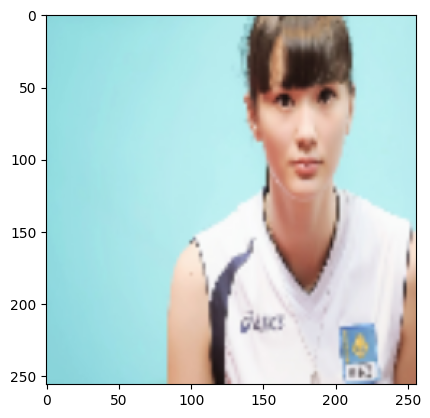

In [260]:
real_img = imgs[0]
real_img = real_img.astype(np.float32)
augmented = combined_augmentations(image = real_img)

fake_img = augmented['image']
fake_img = fake_img / 255.0

plt.imshow(fake_img)

In [261]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
real_img = imgs[0]
real_img = real_img.astype(np.float32)

augmented = combined_augmentations(image = real_img)

fake_img = augmented['image']
fake_img = cv2.resize(fake_img, (512, 512), interpolation = cv2.INTER_AREA)
fake_img = fake_img.astype(np.float32)

real_img = change_to_torch(real_img).unsqueeze(0)
fake_img = change_to_torch(fake_img).unsqueeze(0)

real_img, fake_img = real_img.to(device), fake_img.to(device)
perceptual_loss = ReconstructionPerceptualLoss(vgg).to(device)
loss = perceptual_loss(real_img, fake_img)
print(loss)

tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)


In [262]:
real_img = imgs[0]
real_img = real_img.astype(np.float32)

augmented = combined_augmentations(image = real_img)

fake_img = augmented['image']
fake_img = cv2.resize(fake_img, (512, 512), interpolation = cv2.INTER_AREA)
fake_img = fake_img.astype(np.float32)

In [263]:
paired_transform = PairedTransform(transform)

hr_image, lr_image = paired_transform(real_img, fake_img)

In [264]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensorV2()
])

In [265]:
val_transform = A.Compose([
    ToTensorV2()
])

In [266]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_filenames, image_dir, combined_augmentations, transform):
        self.image_dir = image_dir
        self.image_filenames = os.listdir(image_dir)
        self.combined_augmentations = combined_augmentations
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        hr_image = np.array(Image.open(image_path))
        hr_image = hr_image.astype(np.float32)

        # Create the fake image (low resolution)
        augmented = self.combined_augmentations(image=hr_image)
        lr_image = augmented['image']

        # Normalize LR Image
        lr_image = lr_image / 255.0

        # Apply the paired transform to the high resolution and low resolution images
        paired_transform = PairedTransform(self.transform)
        hr_image, lr_image = paired_transform(hr_image, lr_image)

        # Normalize the HR image
        hr_image = hr_image.float() / 255

        return hr_image, lr_image

In [267]:
from sklearn.model_selection import train_test_split

def create_train_val_datasets(image_dir, combined_augmentations, train_transform, val_transform, val_split=0.2):
    # List all image filenames
    all_image_filenames = os.listdir(image_dir)

    # Split into training and validation filenames
    train_filenames, val_filenames = train_test_split(all_image_filenames, test_size=val_split, random_state=42)

    # Create separate datasets for training and validation
    train_dataset = CustomDataset(train_filenames,
                                  image_dir,
                                  combined_augmentations,
                                  train_transform)

    val_dataset = CustomDataset(val_filenames,
                                image_dir,
                                combined_augmentations,
                                val_transform)

    return train_dataset, val_dataset

In [268]:
train_dataset, val_dataset = create_train_val_datasets(image_dir="dataset",
                                                       combined_augmentations=combined_augmentations,
                                                       train_transform=train_transform,
                                                       val_transform=val_transform)

# Then you can use a DataLoader to create batches and iterate over the dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [271]:
for hr, lr in train_dataloader:
  hr = hr
  hr = hr.to(device)
  # Initialize a local discriminator for each facial component
  local_discriminators = [LocalDiscriminator().to(device) for _ in range(3)]

  # Initialize the FacialComponentLoss with the local discriminators
  facial_component_loss = FacialComponentLoss(local_discriminators).to(device)

  # Run a forward pass of the FacialComponentLoss with your example images and ROIs
  # For the purpose of the example, we will use the same images and ROIs for the real and fake inputs
  loss = facial_component_loss(hr, hr)
  print(loss)

(2, 3, 4)
tensor(4.1495, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
def load_checkpoint(filepath, gen, disc):
    checkpoint = torch.load(filepath)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen = RRDBNet(63, 3, num_block = 23).to(device)
disc = UNetDiscriminatorSN(num_in_ch = 3).to(device)

In [ ]:
!mkdir saved_model

mkdir: cannot create directory ‘saved_model’: File exists


In [ ]:
from tqdm import tqdm
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from torch.autograd import Variable

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

save_path = '/content/results'

# Initializing the losses and optimizers
style_content_loss = StyleContentLoss()
adversarial_loss = BCEWithLogitsLoss()

optimizer_G = optim.AdamW(gen.parameters(), lr=0.0003)
optimizer_D = optim.AdamW(disc.parameters(), lr=0.000003)

epochs = 5000

# Training loop
for epoch in range(epochs):
    print(f'Epoch: {epoch+1}/{epochs}')
    print('-' * 10)

    # Training
    gen.train()  # Set model to training mode
    disc.train()

    running_loss = 0.0

    for hr_image, lr_image in tqdm(train_dataloader):
        # Move the data to the device
        hr_image = hr_image.to(device)
        lr_image = lr_image.to(device)

        # zero the parameter gradients
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()
        G_losses = []
        D_losses = []

        # forward
        with torch.set_grad_enabled(True):
            # Generate a batch of images
            gen_imgs = gen(lr_image)

            # Adversarial ground truths
            valid = Variable(torch.Tensor(np.ones((hr_image.size(0), 1, hr_image.size(2), hr_image.size(3)))), requires_grad=False).to(device)
            fake = Variable(torch.Tensor(np.zeros((hr_image.size(0), 1, hr_image.size(2), hr_image.size(3)))), requires_grad=False).to(device)

            # Adversarial loss
            validity_real = disc(hr_image)
            validity_fake = disc(gen_imgs.detach())

            D_real_loss = adversarial_loss(validity_real, valid)
            D_fake_loss = adversarial_loss(validity_fake, fake)

            D_loss = (D_real_loss + D_fake_loss) / 2

            # Generator loss
            G_loss_content, G_loss_style = style_content_loss(gen_imgs, hr_image)
            G_loss_adv = adversarial_loss(disc(gen_imgs), valid)

            G_loss = 0.01 * G_loss_style + G_loss_content + 0.0001 * G_loss_adv

            G_loss.backward()
            D_loss.backward()

            optimizer_G.step()
            optimizer_D.step()

            # Print losses
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())

            # # Save losses to file
            # with open(f"{epoch+1}_train_loss.txt", "a") as file:
            #     file.write(f'G_loss: {G_loss.item()}, D_loss: {D_loss.item()}\n')

    # Save the generator
    G_losses = np.mean(G_losses)
    D_losses = np.mean(D_losses)
    print(f'G Loss: {G_losses:.4f}, D Loss: {D_losses:.4f}')
    torch.save(gen.state_dict(), f'saved_model/FaceRestoration.pth')

    # Save the discriminator
    torch.save(disc.state_dict(), f'saved_model/Discriminator.pth')

    # after each epoch, we can save and display some results
    if (epoch + 1) % 10 == 0:
        # assuming hr_image, lr_image, gen_imgs are your most recent batch data

        # switch the data to cpu for visualization
        hr_image = hr_image.cpu().detach()
        lr_image = lr_image.cpu().detach()
        gen_imgs = gen_imgs.cpu().detach()

        # get the first images from the batch
        hr_image = hr_image[0]
        lr_image = lr_image[0]
        gen_image = gen_imgs[0]

        # convert tensors to numpy arrays and transpose from (C, H, W) to (H, W, C)
        hr_image_np = hr_image.permute(1, 2, 0).numpy()
        lr_image_np = lr_image.permute(1, 2, 0).numpy()
        gen_image_np = gen_image.permute(1, 2, 0).numpy()

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(lr_image_np)
        axs[0].set_title('LR Image')

        axs[1].imshow(hr_image_np)
        axs[1].set_title('HR Image')

        axs[2].imshow(gen_image_np)
        axs[2].set_title('Generated Image')

        # Saving the plots
        plt.savefig(save_path + '/output_epoch_{}.png'.format(epoch + 1))
        plt.close()

    # Validation every 5 epochs
    # if (epoch + 1) % 5 == 0:
    #     gen.eval()  # Set model to evaluation mode
    #     disc.eval()

    #     with torch.no_grad():
    #         val_losses = []
    #         for hr_image, lr_image in tqdm(val_dataloader):
    #             hr_image = hr_image.to(device)
    #             lr_image = lr_image.to(device)

    #             # forward
    #             gen_imgs = gen(lr_image)

    #             # Generator loss
    #             G_loss_content, G_loss_style = style_content_loss(gen_imgs, hr_image)
    #             G_loss = 0.001 * G_loss_style + G_loss_content

    #             val_losses.append(G_loss.item())

    #         val_loss = np.mean(val_losses)
    #         print(f'Validation Loss: {val_loss}')

    #         # Save losses to file
    #         with open(f"{epoch+1}_val_loss.txt", "a") as file:
    #             file.write(f'G_loss: {G_loss.item()}\n')

    #         # Save validation loss to file
    #         with open(f"{epoch+1}_val_loss.txt", "a") as file:
    #             file.write(f'Validation Loss: {val_loss}\n')

Epoch: 1/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


G Loss: 253376240.0000, D Loss: 0.0006
Epoch: 2/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


G Loss: 565538368.0000, D Loss: 0.0001
Epoch: 3/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


G Loss: 75296208.0000, D Loss: 0.0002
Epoch: 4/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


G Loss: 36319456.0000, D Loss: 0.0002
Epoch: 5/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


G Loss: 36731268.0000, D Loss: 0.0002
Epoch: 6/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


G Loss: 33582048.0000, D Loss: 0.0002
Epoch: 7/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


G Loss: 80662728.0000, D Loss: 0.0001
Epoch: 8/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


G Loss: 56528044.0000, D Loss: 0.0001
Epoch: 9/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


G Loss: 49703600.0000, D Loss: 0.0001
Epoch: 10/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


G Loss: 14575232.0000, D Loss: 0.0002


Epoch: 11/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


G Loss: 15168484.0000, D Loss: 0.0002
Epoch: 12/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


G Loss: 32940614.0000, D Loss: 0.0001
Epoch: 13/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


G Loss: 28264306.0000, D Loss: 0.0001
Epoch: 14/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


G Loss: 26636220.0000, D Loss: 0.0001
Epoch: 15/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


G Loss: 12091131.0000, D Loss: 0.0002
Epoch: 16/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


G Loss: 11931098.0000, D Loss: 0.0002
Epoch: 17/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


G Loss: 11798046.0000, D Loss: 0.0002
Epoch: 18/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


G Loss: 11715280.0000, D Loss: 0.0002
Epoch: 19/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


G Loss: 11771863.0000, D Loss: 0.0002
Epoch: 20/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


G Loss: 21128310.0000, D Loss: 0.0001


Epoch: 21/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


G Loss: 20599070.0000, D Loss: 0.0001
Epoch: 22/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


G Loss: 11848323.0000, D Loss: 0.0001
Epoch: 23/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


G Loss: 19319270.0000, D Loss: 0.0001
Epoch: 24/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


G Loss: 18692704.0000, D Loss: 0.0001
Epoch: 25/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


G Loss: 12235266.0000, D Loss: 0.0001
Epoch: 26/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


G Loss: 12264464.0000, D Loss: 0.0001
Epoch: 27/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


G Loss: 12468963.0000, D Loss: 0.0001
Epoch: 28/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


G Loss: 12575099.0000, D Loss: 0.0001
Epoch: 29/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


G Loss: 12697527.0000, D Loss: 0.0001
Epoch: 30/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


G Loss: 12774728.0000, D Loss: 0.0001


Epoch: 31/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


G Loss: 12789124.0000, D Loss: 0.0001
Epoch: 32/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


G Loss: 14663622.0000, D Loss: 0.0001
Epoch: 33/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


G Loss: 13026287.0000, D Loss: 0.0001
Epoch: 34/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


G Loss: 13139162.0000, D Loss: 0.0001
Epoch: 35/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


G Loss: 13976994.0000, D Loss: 0.0001
Epoch: 36/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


G Loss: 13524228.0000, D Loss: 0.0001
Epoch: 37/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


G Loss: 13202669.0000, D Loss: 0.0001
Epoch: 38/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


G Loss: 13015789.0000, D Loss: 0.0001
Epoch: 39/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


G Loss: 12859934.0000, D Loss: 0.0001
Epoch: 40/5000
----------


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


G Loss: 13320683.0000, D Loss: 0.0001


KeyboardInterrupt: ignored

In [ ]:
img = imgs[0]
img = change_to_torch(img)
img = img.to(device)

img = img.unsqueeze(0)

fake = gen(img)

In [ ]:
fake = fake.squeeze(0)
fake = fake.permute(1, 2, 0)
fake = fake.cpu().detach().numpy()
plt.imshow(fake)